## Efficient Fromtier
Combined using Quantopian and Python for Finance

In [8]:
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import statsmodels
from statsmodels import regression
from scipy import poly1d
from scipy import stats
import scipy.interpolate as sci
import scipy.optimize as sco
from pandas_datareader import data as wb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import cvxopt as opt
from cvxopt import blas, solvers
# Turn off progress printing 
solvers.options['show_progress'] = False
%matplotlib inline
params = {'legend.fontsize': 'x-large','figure.figsize': (20, 10),'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [2]:
# Helper Function to get data from Yahoo
def get_historical_closes(ticker, start_date, end_date):
    # get the data for the tickers.  This will be a panel
    p = wb.DataReader(ticker, "yahoo", start_date, end_date)    
    # convert the panel to a DataFrame and selection only Adj Close
    # while making all index levels columns
    d = p.to_frame()['Adj Close'].reset_index()
    # rename the columns
    d.rename(columns={'minor': 'Ticker','Adj Close': 'Close'}, inplace=True)
    # pivot each ticker to a column
    pivoted = d.pivot(index='Date', columns='Ticker')
    # and drop the one level on the columns
    pivoted.columns = pivoted.columns.droplevel(0)
    return pivoted

# Helper function to get random weights that add to 1
def rand_weights(n):
    ''' Produces n random weights that sum to 1, long only'''
    k = np.random.rand(n)
    return k / sum(k)

### Get Data and Plot Universe

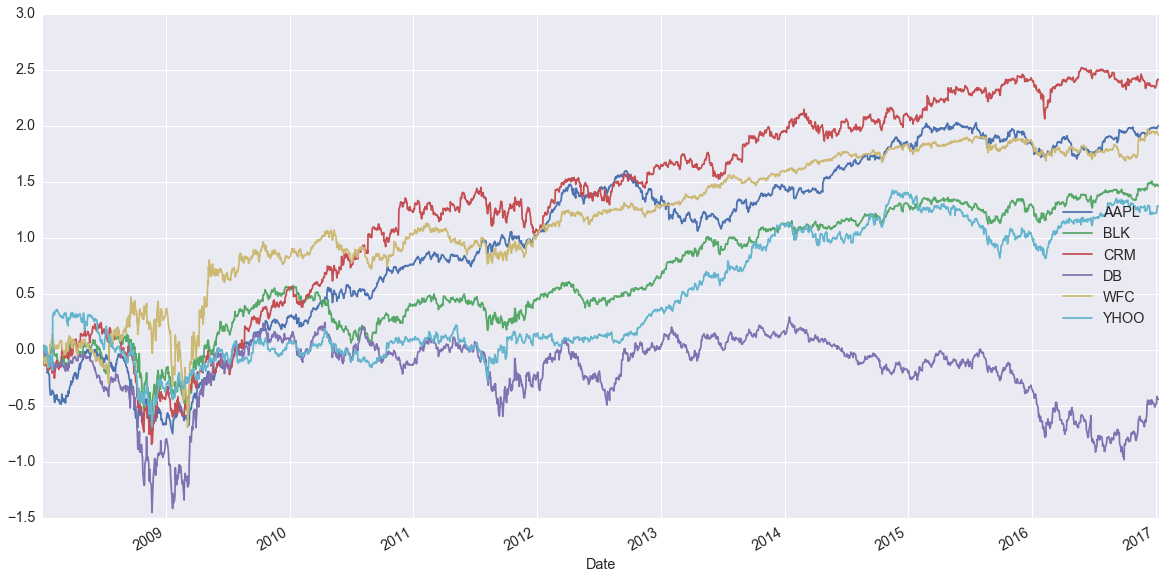

In [32]:
start_dt, end_dt = '2007-12-31', '2017-01-09'
tickers=['CRM', 'AAPL', 'YHOO', 'BLK', 'WFC', 'DB']
#tickers=['IBM', 'GLD', 'XOM', 'AAPL','MSFT', 'TLT', 'SHY', 'HYG']
#tickers=['IBM', 'GLD']
df_data=get_historical_closes(tickers,start_dt,end_dt).pct_change()[1:]
# Plot stock price moves
#Generate return vector
return_vec = df_data.values.T
df_data.cumsum().plot()
plt.legend(bbox_to_anchor=(1, .5), loc='right', ncol=1)

### Generate Random Return Variables

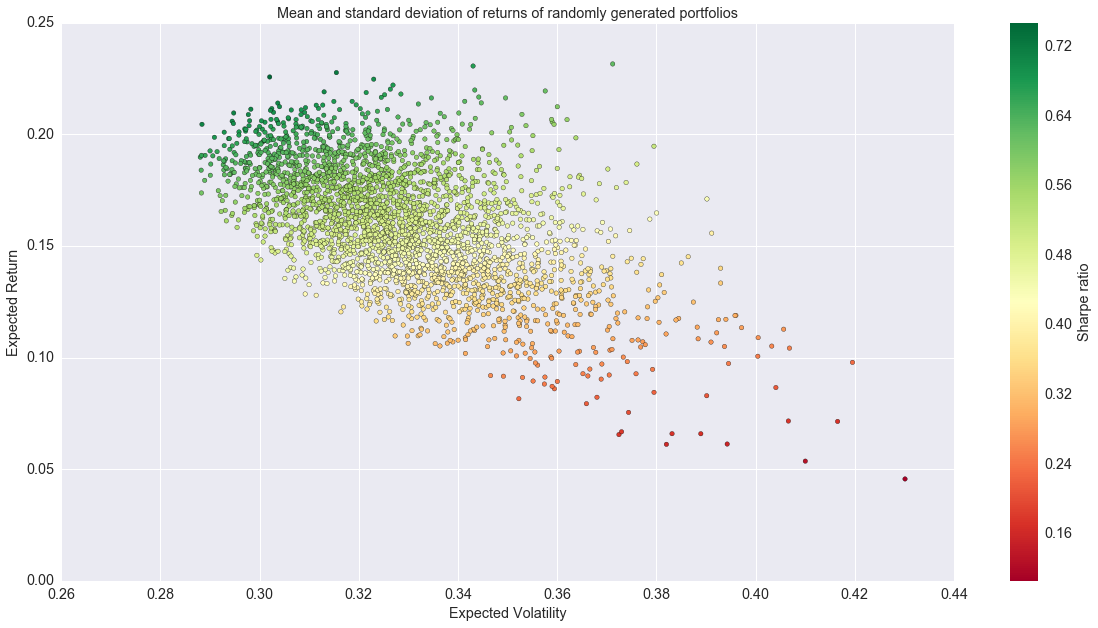

In [20]:
def random_portfolio(returns):
    ''' Returns the mean and standard deviation of returns for a random portfolio'''
    p = np.asmatrix(np.mean(returns, axis=1)) * 252 # annualized return
    w = np.asmatrix(rand_weights(returns.shape[0])) # weight vector
    C = np.asmatrix(np.cov(returns)) * 252          # VCV
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers 
    if sigma > 2:
        return random_portfolio(returns)
    sharpe = np.array(mu, dtype=np.float)/np.array(sigma, dtype=np.float)
    
    return mu, sigma, sharpe

n_portfolios = 3000
means, stds, sharpe = np.column_stack([random_portfolio(return_vec) for _ in range(n_portfolios)])

plt.scatter(stds, means, c=sharpe, cmap=plt.cm.RdYlGn)
plt.ylabel('Expected Return')
plt.xlabel('Expected Volatility')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
plt.colorbar(label='Sharpe ratio');
plt.show();

In [24]:
np.asmatrix(np.cov(return_vec))

matrix([[ 0.00041335,  0.0002352 ,  0.00025125,  0.00030704,  0.00024675,
          0.00018009],
        [ 0.0002352 ,  0.00059608,  0.00033934,  0.00050125,  0.00049459,
          0.00025757],
        [ 0.00025125,  0.00033934,  0.00076521,  0.00043113,  0.0003475 ,
          0.00027624],
        [ 0.00030704,  0.00050125,  0.00043113,  0.00110235,  0.00067198,
          0.00034382],
        [ 0.00024675,  0.00049459,  0.0003475 ,  0.00067198,  0.00099611,
          0.00025568],
        [ 0.00018009,  0.00025757,  0.00027624,  0.00034382,  0.00025568,
          0.00064271]])

## Generate Efficient Frontier using Quadratic Optimizer

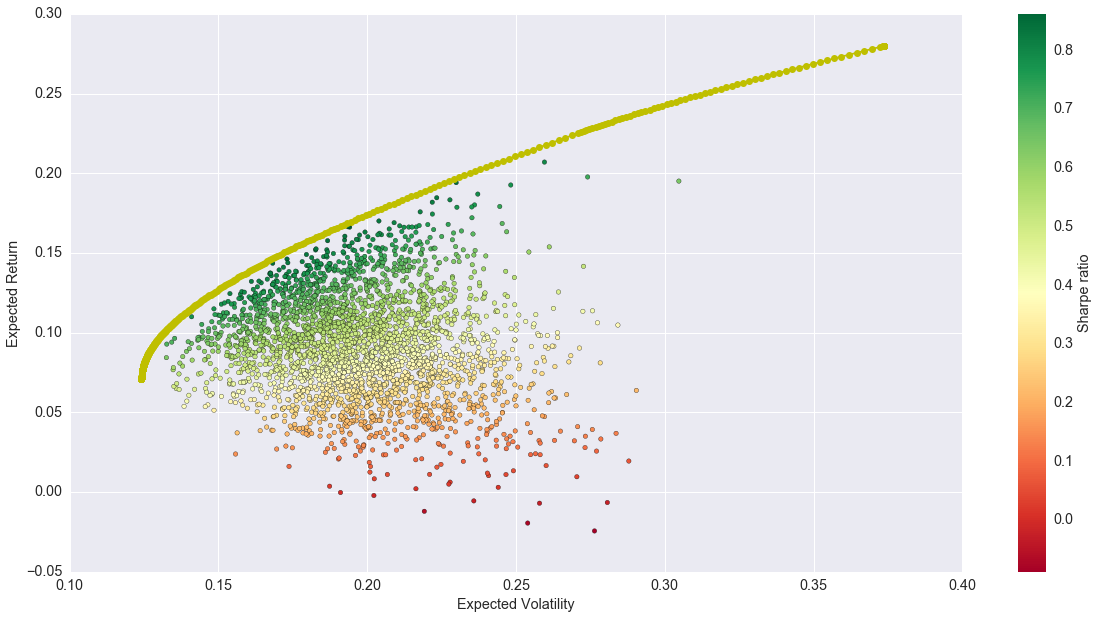

In [10]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 1000
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns)*252)
    pbar = opt.matrix(np.mean(returns, axis=1)*252)
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))  # vertical axis
    A = opt.matrix(1.0, (1, n))  # horizontal
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] #  Negative pbar suggests convexity
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    sharpe = np.array(means, dtype=np.float)/np.array(stds, dtype=np.float)
    return returns, risks, sharpe, portfolios
returns, risks, sharpe, portfolios = optimal_portfolio(return_vec)

plt.scatter(stds, means, c=sharpe, cmap=plt.cm.RdYlGn)
plt.ylabel('Expected Return')
plt.xlabel('Expected Volatility')
plt.plot(risks, returns, 'y-o')
plt.colorbar(label='Sharpe ratio');

In [11]:
# Shrink Size due to Noise
def get_unique(array):
    index_ls, current, interval, index_ls = 0, 0 , 0.00000001, []
    for i in range(array.size):
        if(array[i] - interval > current):
            index_ls.append(i);
            current = array[i];
    return index_ls;

rows_array = np.vstack([returns, risks]).T;

rows_sorted = rows_array[rows_array[:,0].argsort()].T
ret_sorted = rows_sorted[0,:];
std_sorted = rows_sorted[1,:];

index_ls = get_unique(std_sorted);

std_sorted  = std_sorted[index_ls];
ret_sorted  = ret_sorted[index_ls];

ind = np.argmin(std_sorted)
evols = std_sorted[ind:]
erets = ret_sorted[ind:]
tck = sci.splrep(evols, erets)

In [12]:
def f(x):
    ''' Efficient frontier function (splines approximation).'''
    return sci.splev(x, tck, der=0)
def df(x):
    '''First derivative of efficient frontier function.'''
    return sci.splev(x, tck, der=1)

def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt=sco.fsolve(equations, [0.01, 0.5, 0.15])

mu=np.float(f(opt[2]))

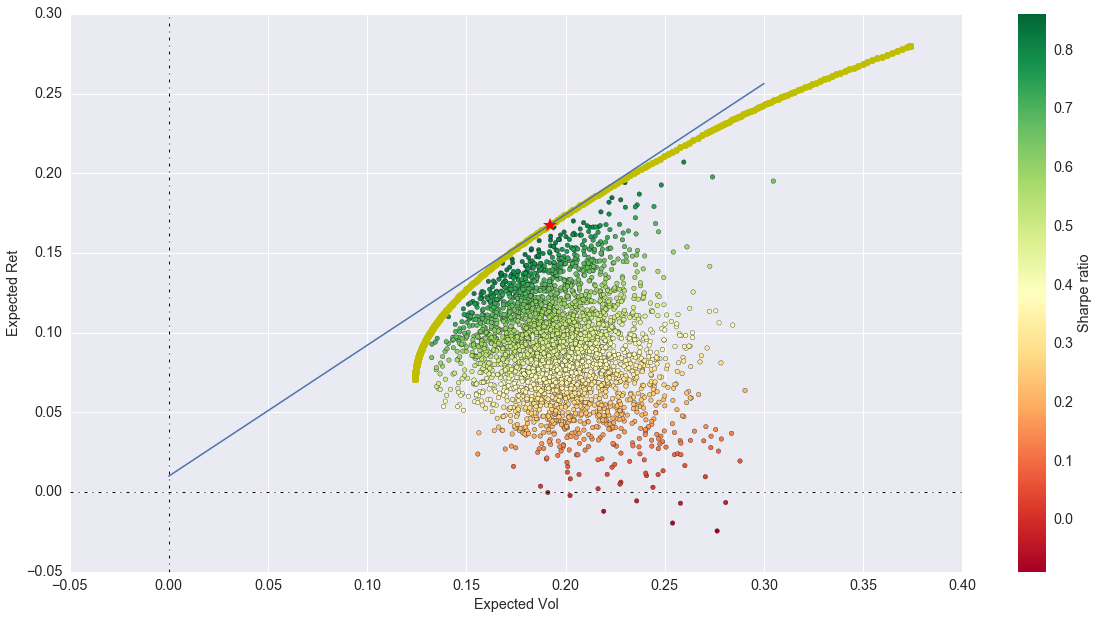

In [13]:
# random portfolio composition
plt.scatter(stds, means, c=sharpe, cmap=plt.cm.RdYlGn)

# efficient frontier
plt.plot(risks, returns, 'y-o')

# capital market line
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)

#optimal port
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0)


plt.grid(True)
plt.axhline(0, color='k', ls='-.', lw=1)
plt.axvline(0, color='k', ls='-.', lw=1)
plt.xlabel('Expected Vol')
plt.ylabel('Expected Ret')
plt.colorbar(label='Sharpe ratio')

In [9]:
import cvxopt as opt
import numpy as np

def get_port(returns, mu):
    #returns=return_vec
    n = len(returns)
    returns = np.asmatrix(returns)

    N = 1000
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns)*252)
    pbar = opt.matrix(np.mean(returns, axis=1)*252)

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))  # vertical axis
    A = opt.matrix(1.0, (1, n))  # horizontal
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = (solvers.qp(mu*S, -pbar, G, h, A, b)['x']) #  Negative pbar suggests convexity
    returns = blas.dot(pbar, portfolios)
    risks = np.sqrt(blas.dot(portfolios, S*portfolios))
    return portfolios, returns, risks

port, ret, std =get_port(return_vec,mu)
print(ret)
print(std)
 

0.23973473777498677
0.265107825452
